In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [55]:
# df = pd.read_csv('/content/drive/MyDrive/CSCI 214: Pattern Recognition/Labs/Lab2/dataset/all_stocks_2006-01-01_to_2018-01-01.csv')
df = pd.read_csv('./dataset/all_stocks_2006-01-01_to_2018-01-01.csv')
dim = 'Low'
df = df[df['Name']=='GOOGL'][['Date', dim]].reset_index(drop=True)
df.head()

,Date,Low
0,2006-01-03,209.32
1,2006-01-04,220.09
2,2006-01-05,220.97
3,2006-01-06,226.85
4,2006-01-09,230.70


### Building a classification dataset for time series.
#### 1. Triple-Barrier labels (take-profit / stop-loss / timeout)
based from Advances in Financial Machine Learning. Ch.3 Labeling
https://agorism.dev/book/finance/ml/Marcos%20Lopez%20de%20Prado%20-%20Advances%20in%20Financial%20Machine%20Learning-Wiley%20%282018%29.pdf

In [56]:
class TripleBarrierModified(Dataset):
  def __init__(self, data, window_length, stride, horizon, k=1.5, timeout_label=0, timeout=True):
    self.data = data
    self.window_length = window_length
    self.stride = stride
    self.horizon = horizon
    self.k = k
    self.timeout_label = timeout_label # "do nothing" label
    self.timeout = timeout

    self.num_samples = (len(data) - window_length - horizon) // stride + 1

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    start_idx = self.stride * idx
    x = self.data[start_idx: start_idx + self.window_length]
    future = self.data[start_idx + self.window_length: start_idx + self.window_length + self.horizon]
    y = self.triple_barrier_labels(x,
                                   future=future,
                                   k = self.k,
                                   timeout_label=self.timeout_label,
                                   timeout=self.timeout)
    if self.timeout:
      return x, y + 1
    
    return x, y

  @staticmethod
  def triple_barrier_labels(x,
                            future,
                            k=1.5,
                            timeout_label=0,
                            timeout=True):
    # set up anchor using mean of the window and the std of window as the volatility scale
    anchor = torch.mean(x)
    anchor_std = torch.std(x, unbiased=False).clamp_min(1e-12)

    # set up upper and lower bariers
    up = anchor + k * anchor_std
    dn = anchor - k * anchor_std
    
    # check which will heat first
    for val in future:
      if val >= up:
        return torch.tensor(1, dtype=torch.long) # if the upper barrier was hit then buy
      if val <= dn:
        return torch.tensor(0, dtype=torch.long) # if the lower barrier was hit first then sell

    if timeout:
      return torch.tensor(timeout_label, dtype=torch.long)
    
    last_val = future[-1]
    if last_val > anchor:
      return torch.tensor(1, dtype=torch.long)
    if last_val < anchor:
      return torch.tensor(0, dtype=torch.long)
    
    return torch.tensor(0, dtype=torch.long) # just sell.


In [57]:
# property
window_length = 7
horizon = 7
stride = 7

data_tensor = torch.tensor(df[dim].values, dtype=torch.float32)
edge = int(0.7 * len(data_tensor))

train_tensor = data_tensor[:edge]
val_tensor = data_tensor[edge:]

tb_train_data = TripleBarrierModified(train_tensor, window_length, stride, horizon, k=1.5, timeout_label=0, timeout=False)
tb_val_data = TripleBarrierModified(val_tensor, window_length, stride, horizon, k=1.5, timeout_label=0, timeout=False)

In [58]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

class ClassificationNeuralNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, output_size)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

def train_fn(model, optimizer, loss_fn, train_loader):
  model.train()

  loss_sum = 0
  count = 0
  for X, y in train_loader:
    preds = model(X)
    loss = loss_fn(preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    count += 1

  return loss_sum / count

def evaluate(model, loader):
  model.eval()
  predictions = []
  targets = []

  for X, y in loader:
    preds = model(X)
    preds = preds.argmax(dim=1).cpu().numpy()
    predictions.extend(preds)
    targets.extend(y.detach().cpu().numpy())

  f1 = f1_score(targets, predictions)

  return f1, predictions, targets

In [59]:
# dataloader
batch_size = 16

tb_train_loader = DataLoader(tb_train_data, batch_size=batch_size, shuffle=True)
tb_test_loader = DataLoader(tb_val_data, batch_size=batch_size, shuffle=True)

# training
tb_model = ClassificationNeuralNetwork(input_size=window_length, output_size=2)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(tb_model.parameters(), lr=0.0001)

num_epochs = 1000

epochs = []
losses = []
f1s = []

for _ in range(num_epochs):
  ave_loss = train_fn(tb_model, optimizer, loss_fn, tb_train_loader)
  f1, __, ___ = evaluate(tb_model, tb_train_loader)

  epochs.append(_)
  losses.append(ave_loss)
  f1s.append(f1)

training_results = pd.DataFrame({
    'epochs': epochs,
    'losses': losses,
    'f1-scores': f1s
})
training_results


,epochs,losses,f1-scores
0,0,0.849169,0.754098
1,1,0.573171,0.789189
2,2,0.566255,0.794667
3,3,0.563748,0.784416
4,4,0.571993,0.794444
...,...,...,...
995,995,0.511348,0.792453
996,996,0.505178,0.819945
997,997,0.490498,0.819767
998,998,0.498093,0.830601


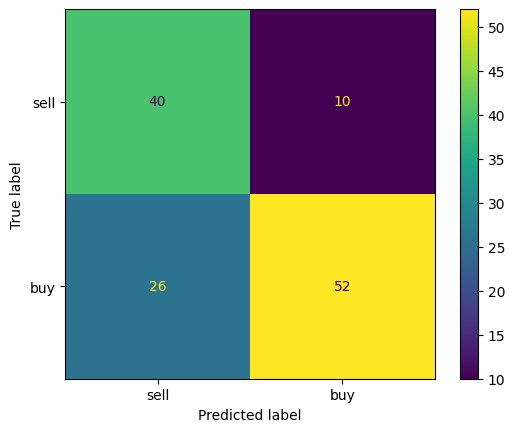

In [ ]:
f1, preds, targets = evaluate(tb_model, tb_test_loader)

confusion_mat = confusion_matrix(targets, preds)
matrix = ConfusionMatrixDisplay(confusion_mat, display_labels=['sell', 'buy'])
matrix.plot()
plt.show()

#### Classification dataset 2: Moving average
https://discuss.pytorch.org/t/doing-a-very-basic-simple-moving-average/5003 --- utilize avg_pool1d - i chat gpted how to use avg_pool1d

In [61]:
import torch.nn.functional as F

class MovingAveDataset(Dataset):
    """
    Label = 1 if MA(end + horizon) - MA(end) > epsilon, else 0.
    """
    def __init__(self, prices, window_length, stride, horizon, ma_length = 10, epsilon = 0.0):
        self.prices = prices
        self.window_length = window_length
        self.stride = stride
        self.horizon = horizon
        self.ma_length = ma_length # Moving average length
        self.epsilon = epsilon

        # precompute simple moving average (aligned to window ends)
        prices_3d = prices.view(1, 1, -1).float()
        self.simple_moving_average = F.avg_pool1d(
            prices_3d, kernel_size=self.ma_length, stride=1
        ).view(-1)
        self.sma_offset = self.ma_length - 1

        series_length = len(prices)
        first_start = max(0, self.ma_length - self.window_length)
        last_start = series_length - self.window_length - self.horizon
        self.start_indices = list(range(first_start, last_start + 1, self.stride))

    def __len__(self):
        return len(self.start_indices)

    def __getitem__(self, sample_index: int):
        start_index = self.start_indices[sample_index]
        end_index = start_index + self.window_length - 1

        x = self.prices[start_index : start_index + self.window_length]

        sma_now = self.simple_moving_average[end_index - self.sma_offset]
        sma_future = self.simple_moving_average[end_index + self.horizon - self.sma_offset]
        y = 1 if float(sma_future - sma_now) > self.epsilon else 0

        return x, torch.tensor(y, dtype=torch.long)

In [62]:
# property
window_length = 7
horizon = 7
stride = 7

data_tensor = torch.tensor(df[dim].values, dtype=torch.float32)
edge = int(0.7 * len(data_tensor))

train_tensor = data_tensor[:edge]
val_tensor = data_tensor[edge:]

ma_train_data = MovingAveDataset(train_tensor, window_length, stride, horizon, ma_length=10, epsilon=0.001)
ma_val_data = MovingAveDataset(val_tensor, window_length, stride, horizon, ma_length=10, epsilon=0.001)

In [63]:
# dataloader
batch_size = 16

ma_train_loader = DataLoader(ma_train_data, batch_size=batch_size, shuffle=True)
ma_test_loader = DataLoader(ma_val_data, batch_size=batch_size, shuffle=True)

# training
ma_model = ClassificationNeuralNetwork(input_size=window_length, output_size=2)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(ma_model.parameters(), lr=0.0001)

num_epochs = 1000

epochs = []
losses = []
f1s = []

for _ in range(num_epochs):
  ave_loss = train_fn(ma_model, optimizer, loss_fn, ma_train_loader)
  f1, __, ___ = evaluate(ma_model, ma_train_loader)

  epochs.append(_)
  losses.append(ave_loss)
  f1s.append(f1)

training_results = pd.DataFrame({
    'epochs': epochs,
    'losses': losses,
    'f1-scores': f1s
})
training_results


,epochs,losses,f1-scores
0,0,55.223111,0.000000
1,1,36.993113,0.000000
2,2,19.341474,0.000000
3,3,4.068067,0.728814
4,4,1.381311,0.000000
...,...,...,...
995,995,0.515079,0.798956
996,996,0.494287,0.738562
997,997,0.481597,0.778816
998,998,0.514009,0.641791


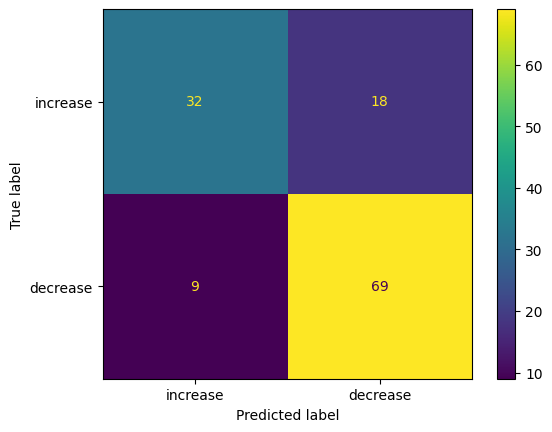

In [64]:
f1, preds, targets = evaluate(ma_model, ma_test_loader)

confusion_mat = confusion_matrix(targets, preds)
matrix = ConfusionMatrixDisplay(confusion_mat, display_labels=['increase', 'decrease'])
matrix.plot()
plt.show()

# Guide question codes

In [65]:
# class balance
from collections import Counter

def class_balance(loader):
    all_y = []
    for X, y in loader:
        all_y.extend(y.tolist())
    return Counter(all_y)

print("TRIPLE-BARRIER")
print("train counts:", class_balance(tb_train_loader))
print("val counts:  ", class_balance(tb_test_loader))

print('')

print("MOVING-AVERAGE")
print("train counts:", class_balance(ma_train_loader))
print("val counts:  ", class_balance(ma_test_loader))

TRIPLE-BARRIER
train counts: Counter({1: 170, 0: 130})
val counts:   Counter({1: 70, 0: 58})

MOVING-AVERAGE
train counts: Counter({1: 172, 0: 128})
val counts:   Counter({1: 78, 0: 50})
